# CUSTOMER SEGMENTATION PROJECT

## Goals:

1. Connect to the database.
2. Query the tables in the database.
3. Handle with cancelled orders.
4. Analysis and segmentations of customer by: Country, Seasonality, Profile Customers using the RFM Score method.
5. Visualize the segments and get conclusions.
6. Make recommendations for the company.

In [59]:
# Import the libraries needed
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style and palette
sns.set_style("whitegrid")
palette = sns.color_palette("husl", as_cmap=True)

### 1. Connect to the database
Connect with the sql database and list the tables:
- online_transactions
- stock_description
- online_transactions_cleaned

In [3]:
conn = sqlite3.connect('../data/bootcamp_db')

In [4]:
# You can run this code, if you need a reminder of the tables in the database

sql_query = """SELECT name 
               FROM sqlite_master 
               WHERE type='table';"""

cursor = conn.cursor()

# executing our sql query
cursor.execute(sql_query)

 
# printing all tables list
print(f"List of tables in the database:\n{cursor.fetchall()}")

List of tables in the database:
[('online_transactions',), ('stock_description',), ('online_transactions_cleaned',)]


### 2. Query the table
In this project we work with the online_transactions_cleaned, that contains the preprocess data:

- Cleaning and preprocessing the data is completed.
- Handling with duplicates and null values.
- Quantities with negative values were excluded.

In [5]:
query = """
       SELECT *
       FROM online_transactions_cleaned
       WHERE quantity >= 0 AND price >= 0;
       """

otc_data = pd.read_sql(query, conn)

In [6]:
otc_data.shape

(391334, 9)

In [7]:
otc_data.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,1.25,24,30.00,u12583,France
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,2010-12-01 09:02:00,2.55,6,15.30,u1785,United Kingdom
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,1.95,10,19.50,u14688,United Kingdom
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,2.95,1,2.95,u15311,United Kingdom
4,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,5.95,2,11.90,u15311,United Kingdom


In [8]:
otc_data.describe()

,price,quantity,total_order_value
count,391334.000000,391334.000000,391334.000000
mean,2.920468,13.174199,22.372879
std,7.267548,181.871884,310.911086
min,0.000000,1.000000,0.000000
25%,1.250000,2.000000,4.950000
50%,1.950000,6.000000,11.900000
75%,3.750000,12.000000,19.800000
max,1599.260000,80995.000000,168469.600000


## 3. Handle with returned or cancelled orders.

In this step we remove the transactions where an invoice and its corresponding return (negative quantity) and identify and eliminate these pairs from our results.

In [9]:
query = """

WITH transaction_pairs AS (
    SELECT
        t1.invoice AS invoice1,
        t2.invoice AS invoice2,
        t1.stock_code,
        t1.description,
        t1.invoice_date AS invoice_date1,
        t2.invoice_date AS invoice_date2,
        t1.price,
        t1.quantity AS quantity1,
        t2.quantity AS quantity2,
        t1.customer_id,
        t1.country
    FROM
        online_transactions_cleaned t1
    JOIN
        online_transactions_cleaned t2
    ON
        t1.stock_code = t2.stock_code AND
        t1.description = t2.description AND
        t1.price = t2.price AND
        t1.customer_id = t2.customer_id AND
        t1.quantity = -t2.quantity AND
        t1.quantity > 0
)
-- Select all transactions that are not part of a matched pair
SELECT
    *
FROM
    online_transactions_cleaned
WHERE
    invoice NOT IN (SELECT invoice1 FROM transaction_pairs)
    AND
    invoice NOT IN (SELECT invoice2 FROM transaction_pairs)
    AND quantity > 0;
    """

customer_data = pd.read_sql(query, conn)

In [10]:
customer_data.describe()

,price,quantity,total_order_value
count,324486.000000,324486.000000,324486.000000
mean,2.891756,12.865766,21.789280
std,7.658631,47.835449,95.716167
min,0.000000,1.000000,0.000000
25%,1.250000,2.000000,4.950000
50%,1.950000,6.000000,12.500000
75%,3.750000,12.000000,19.800000
max,1599.260000,12540.000000,38970.000000


In [11]:
customer_data.shape

(324486, 9)

In [12]:
customer_data.head()

,invoice,stock_code,description,invoice_date,price,quantity,total_order_value,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,2010-12-01 08:45:00,1.25,24,30.00,u12583,France
1,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,2010-12-01 09:37:00,1.95,10,19.50,u14688,United Kingdom
2,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2010-12-01 09:41:00,2.95,1,2.95,u15311,United Kingdom
3,536381,15056BL,EDWARDIAN PARASOL BLACK,2010-12-01 09:41:00,5.95,2,11.90,u15311,United Kingdom
4,536381,22438,BALLOON ART MAKE YOUR OWN FLOWERS,2010-12-01 09:41:00,1.95,1,1.95,u15311,United Kingdom


## 4. Analysis and segmentations of customers by: 
- Seasonality: Distribution of invoice per month and per season.
- Country - Top 10 Countries by number of orders and total order value. UK and Non-UK Customers.
- Profile Customers by RFM Score

### Seasonality Analysis:

### Distribution of Invoices per Month:

1. Visualize the distribution of invoices per month.
   - The bar chart displays the distribution of invoices across different months. This helps in understanding the seasonality of transactions.
3. Identify the month with the highest number of transactions.
   - The month with the Highest Number of Transactions: November (+5,635)

In [13]:
# Convert invoice_date to datatime format
customer_data['invoice_date'] = pd.to_datetime(customer_data['invoice_date'])

In [14]:
# Extract month from invoice_date
customer_data['month'] = customer_data['invoice_date'].dt.month

# Distribution of invoices per month
invoices_per_month = customer_data['month'].value_counts().sort_index()

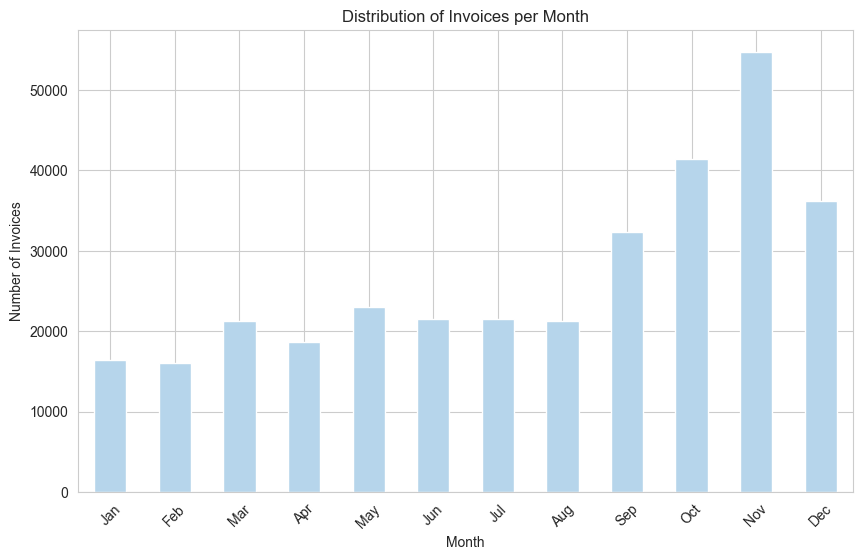

In [15]:
# Visualize the distribution
plt.figure(figsize=(10, 6))
invoices_per_month.plot(kind='bar', color = '#b6d5eb')
plt.title('Distribution of Invoices per Month')
plt.xlabel('Month')
plt.ylabel('Number of Invoices')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

### Distribution of Invoices per Season:
1. Visualize the distribution of invoices per season.
    - The number of orders is relatively consistent across seasons Spring, Summer and Winter, with a markable increased during Autumn.

In [16]:
# Extract month and year from the invoice_date

customer_data['month'] = customer_data['invoice_date'].dt.month
customer_data['year'] = customer_data['invoice_date'].dt.year

In [17]:
# Define a function to determine the season from the month

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [18]:
# Add a new column for season
customer_data['season'] = customer_data['month'].apply(get_season)

In [19]:
# Segmenting by season
season_segment = customer_data.groupby('season').agg(
    num_orders=('invoice', 'nunique'),
    total_order_value=('total_order_value', 'sum')
).sort_values('num_orders', ascending=False).reset_index()

In [20]:
season_segment

,season,num_orders,total_order_value
0,Autumn,5635,2624671.851
1,Winter,3616,1534420.900
2,Summer,3466,1517233.551
3,Spring,3455,1393989.851


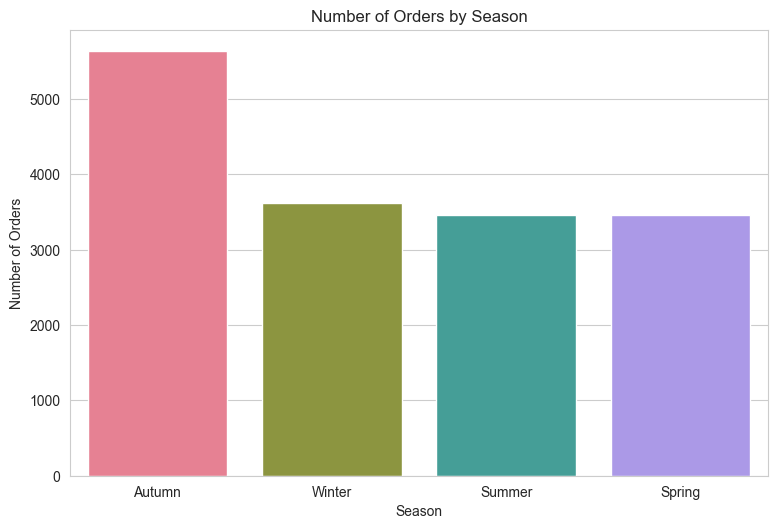

In [21]:
# Visualizations
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 3)
sns.barplot(x='season', y='num_orders', data=season_segment, palette='husl')
plt.title('Number of Orders by Season')
plt.xlabel('Season')
plt.ylabel('Number of Orders')

plt.tight_layout()
plt.show()

## Country segmentation analysis:

1. Relation between UK Customer and Non-UK Customers
2. Top 10 most popular geographical locations.
3. Top 10 countries with the highest spending.


### UK Customers vs. Non-UK Customers:
1. Visualize the distribution of customers in this two regions.
    - The number of transactions and total spent from UK Customers is 90% higher that the rest of countries.

In [22]:
# creating segments based on the country

def create_customer_segments(i):
    if i == "United Kingdom":
        return "UK Customer"
    else:
        return "Non-UK Customer"

In [23]:
customer_data['customer_segment']  = customer_data.country.apply(create_customer_segments)

In [24]:
# Segmenting by country
customer_segment = customer_data.groupby('customer_segment').agg(
    num_orders=('invoice', 'nunique'),
    total_order_value=('total_order_value', 'sum')
).sort_values('num_orders', ascending=False).reset_index()

In [25]:
customer_segment

,customer_segment,num_orders,total_order_value
0,UK Customer,14694,5951900.603
1,Non-UK Customer,1478,1118415.550


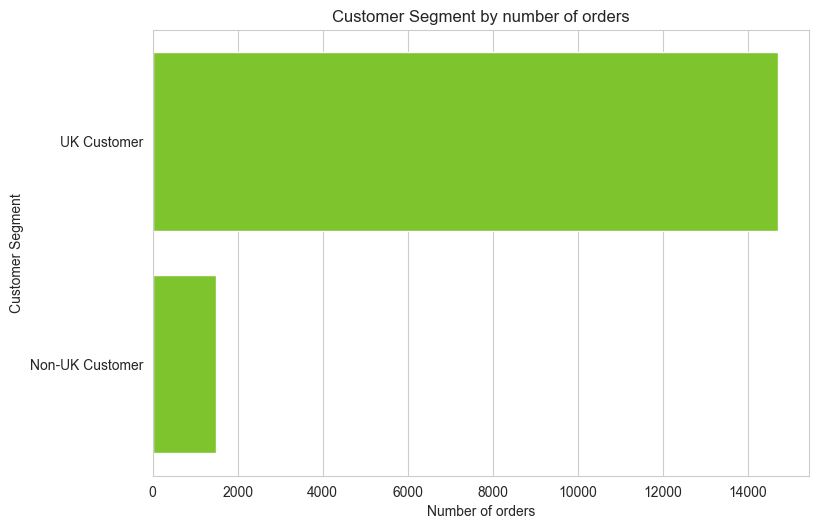

In [54]:
# Visualizations
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
sns.barplot(x='num_orders', y='customer_segment', data=customer_segment.sort_values('num_orders', ascending=False), color = '#80dd13')
plt.title('Customer Segment by number of orders')
plt.xlabel('Number of orders')
plt.ylabel('Customer Segment')

plt.tight_layout()
plt.show()

## Top 10 most popular geographical locations
1. Visualize the distribution of customers in 10 principals countries.
    - Behind United Kingdom are Germany, France, EIRE, Belgium, Netherlands and Spain the countries with a considerable number of orders.

In [27]:
# Segmenting by Top 10 countries
country_segment = customer_data.groupby('country').agg(
    num_orders=('invoice', 'nunique'),
    total_order_value=('total_order_value', 'sum')
).sort_values('num_orders', ascending=False).reset_index()

country_segment.head(10)

,country,num_orders,total_order_value
0,United Kingdom,14694,5951900.603
1,Germany,375,158463.990
2,France,331,152044.460
3,EIRE,105,119586.820
4,Belgium,93,35376.850
5,Netherlands,87,222637.510
6,Spain,79,47880.870
7,Portugal,46,25202.720
8,Australia,44,88092.140
9,Switzerland,40,46907.400


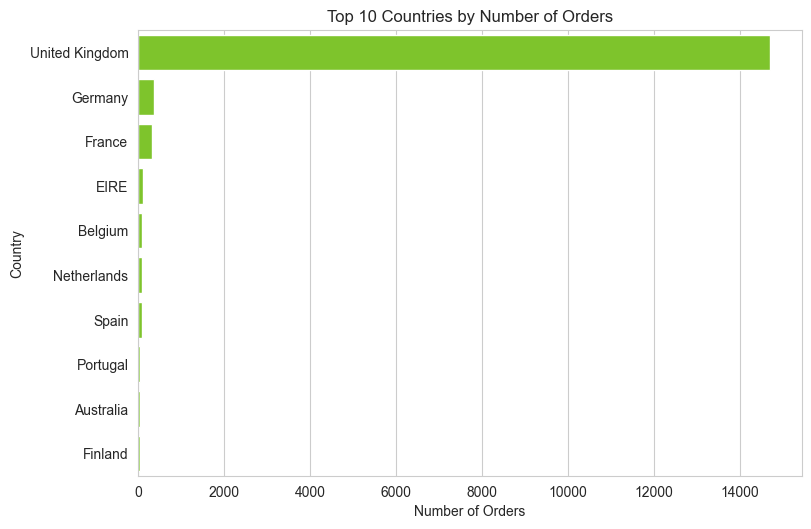

In [28]:
# Visualizations
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
sns.barplot(x='num_orders', y='country', data=country_segment.sort_values('num_orders', ascending=False).head(10), color='#80dd13')
plt.title('Top 10 Countries by Number of Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Country')

plt.tight_layout()
plt.show()

### Top 10 Countries with the highest spending
1. Visualize the distribution of customers in 10 countries with high total order value.
    - In this case behind United Kingdom are Netherlands, Germany, France, EIRE and Australia the countries with a considerable total order value.

In [29]:
# Segmenting by Top 10 countries
country_segment_spent = customer_data.groupby('country').agg(
    num_orders=('invoice', 'nunique'),
    total_order_value=('total_order_value', 'sum')
).sort_values('total_order_value', ascending=False).reset_index()

country_segment_spent.head(10)

,country,num_orders,total_order_value
0,United Kingdom,14694,5951900.603
1,Netherlands,87,222637.510
2,Germany,375,158463.990
3,France,331,152044.460
4,EIRE,105,119586.820
5,Australia,44,88092.140
6,Spain,79,47880.870
7,Switzerland,40,46907.400
8,Belgium,93,35376.850
9,Norway,28,31080.890


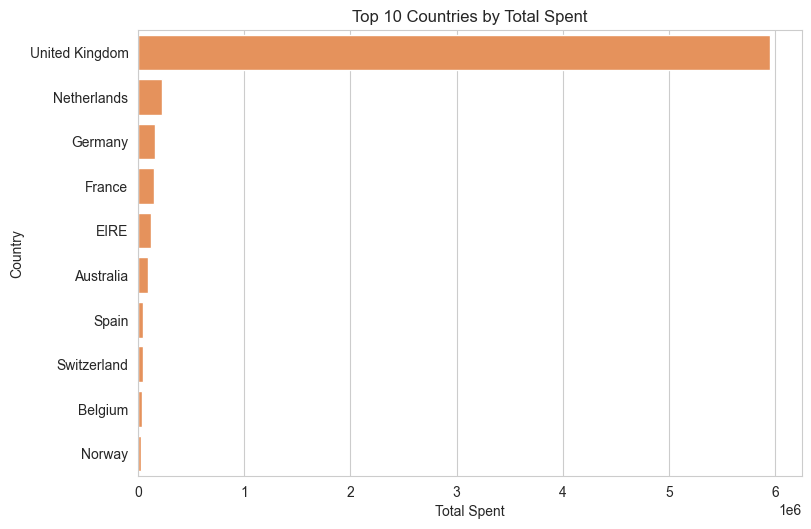

In [30]:
# Visualizations
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
sns.barplot(x='total_order_value', y='country', data=country_segment_spent.sort_values('total_order_value', ascending=False).head(10), color='#fc8d45')
plt.title('Top 10 Countries by Total Spent')
plt.xlabel('Total Spent')
plt.ylabel('Country')

plt.tight_layout()
plt.show()

## Profile Customer Analysis:
Identify the profile customers based on their spending and order frequency and define 4 segments:

#### 1. High spenders:
   - Most important customers and frequent buyers. (Highest scores across all three RFM metrics)
#### 2. Loyal Spenders:
   - Customers needing Engagement. (High frequency and monetary scores, regardless of recency)
#### 3. Regular Spenders:
   - Consistent buyers with moderate spending. (High recency and frequency scores)
#### 4. Low Spenders:
   - Customers Needing Enticement and those who haven't purchased recently. (Low recency scores)

### Recency, Frequency and Monetary value

In [62]:
# Calculate Recency, Frequency and Monetary value for each customer 
rfm_data = customer_data.groupby(['customer_id']).agg({
    'invoice_date': lambda x: (pd.to_datetime('2012-01-01') - x.max()).days,
    'invoice': 'nunique',
    'total_order_value': 'sum'})

# Rename the columns 
rfm_data.rename(columns={'invoice_date': 'Recency',
                         'invoice': 'Frequency',
                         'total_order_value': 'MonetaryValue'}, inplace=True)

rfm_data.head(10)

,Recency,Frequency,MonetaryValue
customer_id,,,
u12347,24,7,4310.00
u12348,97,4,1437.24
u12349,40,1,1457.55
u1235,332,1,294.40
u12352,58,4,1040.73
u12353,226,1,89.00
u12354,254,1,1079.40
u12355,236,1,459.40
u12356,44,3,2487.43


In [63]:
# Scoring RFM metrics
rfm_data['recency_score'] = pd.qcut(rfm_data['Recency'], 5, labels=[5, 4, 3, 2, 1])  # More recent, higher score
rfm_data['frequency_score'] = pd.qcut(rfm_data['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm_data['monetary_score'] = pd.qcut(rfm_data['MonetaryValue'], 5, labels=[1, 2, 3, 4, 5])

# Combine scores into a single RFM score
rfm_data['RFM_Score'] = rfm_data['recency_score'].astype(str) + rfm_data['frequency_score'].astype(str) + rfm_data['monetary_score'].astype(str)

In [64]:
# Define customer segments based on RFM Score
def segment_customer(row):
    if row['RFM_Score'] in ['555', '554', '545', '544']:
        return 'High Spenders'
    elif row['RFM_Score'][1] == '5':
        return 'Loyal Spenders'
    elif row['RFM_Score'][0] == '5':
        return 'Regular Spenders'
    else:
        return 'Lower Spenders'

rfm_data['Segment'] = rfm_data.apply(segment_customer, axis=1)

# Count of each segment
segment_counts = rfm_data['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

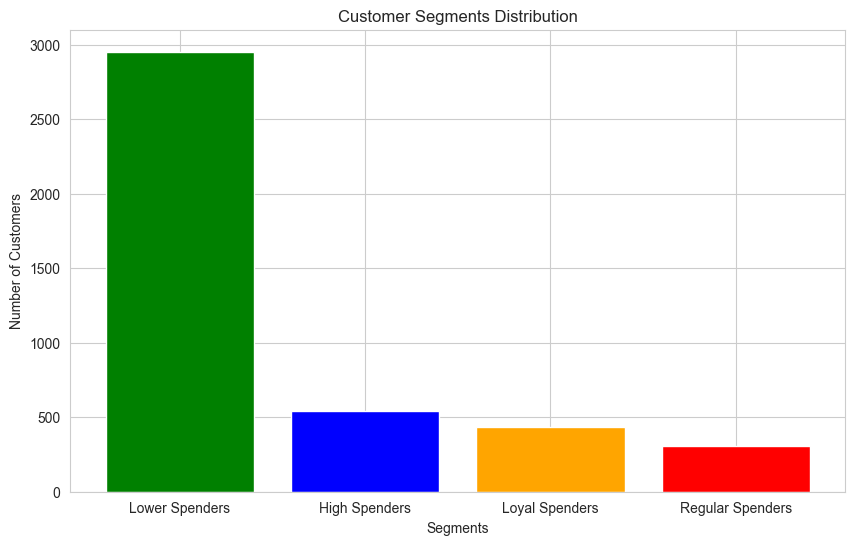

In [65]:
# Plotting the segments
plt.figure(figsize=(10, 6))
plt.bar(segment_counts['Segment'], segment_counts['Count'], color=['green', 'blue', 'orange', 'red', 'gray'])
plt.title('Customer Segments Distribution')
plt.xlabel('Segments')
plt.ylabel('Number of Customers')
plt.show()

In [66]:
segment_counts

,Segment,Count
0,Lower Spenders,2952
1,High Spenders,543
2,Loyal Spenders,434
3,Regular Spenders,307


In [79]:
# Display the top customers based on RFM Score
top_customers = rfm_data.sort_values(by='RFM_Score', ascending=False).head(10)
top_customers

,Recency,Frequency,MonetaryValue,recency_score,frequency_score,monetary_score,RFM_Score,Segment
customer_id,,,,,,,,
u12347,24,7,4310.00,5,5,5,555,High Spenders
u12682,25,31,11019.82,5,5,5,555,High Spenders
u14031,29,16,13284.86,5,5,5,555,High Spenders
u14503,25,6,3543.26,5,5,5,555,High Spenders
u16133,25,28,13043.09,5,5,5,555,High Spenders
u16143,25,6,2424.94,5,5,5,555,High Spenders
u16145,30,11,3799.49,5,5,5,555,High Spenders
u17769,34,8,2797.42,5,5,5,555,High Spenders
u15498,24,27,13316.40,5,5,5,555,High Spenders


In [76]:
# Display the low customers based on CLV
low_customers = rfm_data.sort_values(by='RFM_Score', ascending=True).head(10)
low_customers

,Recency,Frequency,MonetaryValue,recency_score,frequency_score,monetary_score,RFM_Score,Segment
customer_id,,,,,,,,
u13898,347,1,155.93,1,1,1,111,Lower Spenders
u12551,379,1,168.00,1,1,1,111,Lower Spenders
u13561,237,1,141.86,1,1,1,111,Lower Spenders
u13002,340,1,120.95,1,1,1,111,Lower Spenders
u12559,332,1,75.60,1,1,1,111,Lower Spenders
u12565,310,1,145.92,1,1,1,111,Lower Spenders
u14576,394,1,35.40,1,1,1,111,Lower Spenders
u13948,382,1,102.00,1,1,1,111,Lower Spenders
u12573,249,1,160.54,1,1,1,111,Lower Spenders


## Recommendations for the company

### Target High Spenders:
- These customers are the most valuable. 
- Providing them with VIP treatment, such as early access to sales, personalized recommendations, and exclusive events, can help retain their loyalty.
- Regularly analyzing their purchasing behavior to understand their preferences can help in tailoring marketing strategies..

### Incentivate Loyal Spenders:
- These customers are more engaged than regular buyers.
- Maintaining regular communication through newsletters and exclusive deals can help retain them.
- Offering loyalty programs could further incentivize these customers to increase their spending.

### Engage Regular Spenders:
- Maintain regular engagement through newsletters, updates on new products, and special events.
- Offer incentives for referrals to bring in new customers through existing regular customers.

### Entice Back Low Spenders:
- These customers might be targeted with incentives such as discounts or special offers to increase their purchasing frequency and spending.
- Send personalized marketing emails or promotions based on their browsing and purchasing history.